In [1]:
import wikipedia
import igraph
import json
import unidecode

In [2]:
!pip install unidecode

In [3]:
def check_result(search_query, search_result):
    print(type(search_query))
    print(type(search_result))
    if(search_query.lower() == search_result.lower()):
        return True
    else:
        return False

In [37]:
class WikipediaGraph(igraph.Graph):
    def __init__(self, start_page, num_iterations=1):
        super().__init__()
        self.start_page = start_page
        self.num_iterations = num_iterations
        self.unicode_errors = []
        
        self.add_page_to_graph(self.start_page)


###
# Instance Methods
###        
    
    def is_page_in_graph(self, page_name):
        """
            Checks whether a page named "page_name" is in the graph
        """
        page_vertex = None
        try:
            page_vertex = self.vs.find(name=page_name)
            return True
        except ValueError:
            return False
        
    def is_page_mapped(self, page_name):
        """
            Checks whether page "page_name" has been mapped
        """
        if self.is_page_in_graph(page_name) == False:
            return False
        if self.vs.find(name=page_name)["is_mapped"] == False:
            return False
        return True
    
    def add_page_to_graph(self, page_name):
        max_map = 10
        count = 1
        
        page = None
        try:
            page = wikipedia.page(page_name)
        except (wikipedia.DisambiguationError, wikipedia.PageError) as e:
            print(page_name)
            return
        print(page_name)
#         page_links = map(lambda x: unicodedata.normalize('NFKD', x).encode('ascii','ignore'), page.links)
        page_links = map(lambda x: unidecode.unidecode(x), page.links)
    
        # if page isn't in graph
        if self.is_page_in_graph(page_name) == False:
            self.add_vertex(name = page_name) # add the page to the graph
            self.vs.find(name = page_name)["is_mapped"] = True
            for link in page_links:
                if count > max_map:
                    break
                count += 1
                
                if self.is_page_in_graph(link) == False: # if the target page isn't already in the graph
                    link_vertex = self.add_vertex(name = link)
                    self.vs.find(name = link)["is_mapped"] = False
                    
                self.add_edge(page_name, link) # connectes the source and target pages
        
        # if page is in graph but hasn't been mapped
        if self.is_page_mapped(page_name) == False and self.is_page_in_graph(page_name) == True:
            self.vs.find(name = page_name)["is_mapped"] = True
            for link in page_links:
                if count > max_map:
                    break
                count += 1
                
                if self.is_page_in_graph(link) == False: # if the target page isn't already in the graph
                    link_vertex = self.add_vertex(name = link)
                    self.vs.find(name = link)["is_mapped"] = False
                    
                self.add_edge(page_name, link) # connectes the source and target pages
        
        if self.is_page_mapped(page_name) == True and self.is_page_in_graph(page_name) == True:
            return
    
    def write(self):
        file_name = "{}_v_{}_e_{}.graphml".format(self.start_page, self.vcount(), self.ecount())
        print(file_name)
        return super(WikipediaGraph, self).write(file_name, format="graphml")

###
# Class Methods
###
        
    def check_result(search_query, search_result):
        print(type(search_query))
        print(type(search_result))
        if(search_query.lower() == search_result.lower()):
            return True
        else:
            return False

In [38]:
g = WikipediaGraph("Quantum Mechanics")

Quantum Mechanics


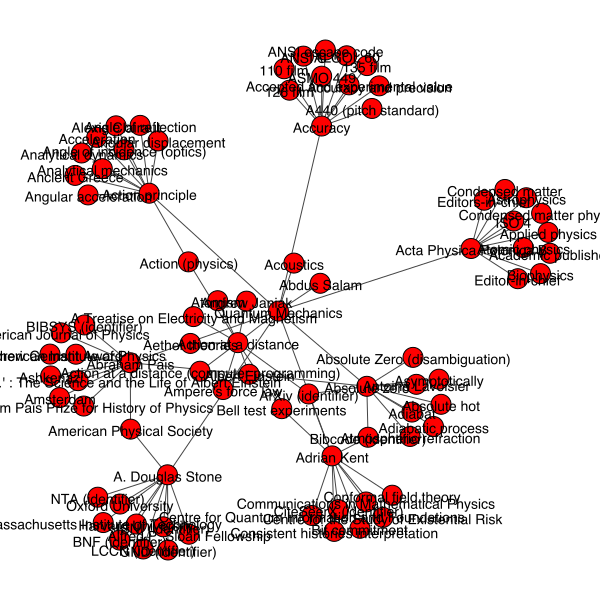

In [46]:
visual_style = {}
visual_style["vertex_label"] = g.vs["name"]
visual_style["layout"] = g.layout("fr")
visual_style["margin"] = 50

igraph.plot(g, **visual_style)

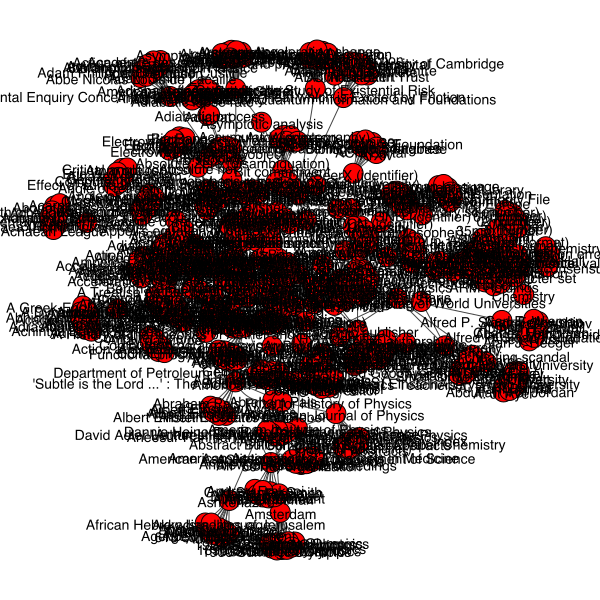

In [49]:
visual_style = {}
visual_style["vertex_label"] = g.vs["name"]
visual_style["layout"] = g.layout("fr")
visual_style["margin"] = 50

igraph.plot(g, **visual_style)

In [23]:
# g.write_adjacency("adjacency.json") #writes adjacency matrix. Definitely not json.
# g.write_edgelist("edges.json") # also not json
g.write_ncol("ncol.json")

<ipython-input-23-08a116e4410e>:3: RuntimeWarning: weights attribute does not exists at src/io/ncol.c:265
  g.write_ncol("ncol.json")


In [52]:
# {"id": "Myriel", "group": 1},
# {"source": "Napoleon", "target": "Myriel", "value": 1},

test_json = {}

test_json["nodes"] = []
test_json["links"] = []
for i, vertex in enumerate(g.vs):
    if i == 0: # change the group so the node is a different color
        test_json["nodes"].append({"id": vertex["name"], "group": 0})
    else:
        test_json["nodes"].append({"id": vertex["name"], "group": 1})
for edge in g.es:
    test_json["links"].append({"source": g.vs[edge.source]["name"],
                               "target": g.vs[edge.target]["name"],
                               "value": 1})
# print(json.dumps(test_json, indent=1))

with open("../static/data/hand_wrangled4.json", "w") as f:
    json.dump(test_json, f)

In [53]:
# for i in range(15):
#     print(g.es[i])

# print(g.es[0].source)
# print(g.es[0].target)

# print(g.vs[g.es[0].source]["name"])
# g.vs[g.es[0].target]["name"]

In [32]:
for i in range(15):
    print(g.vs[i])

igraph.Vertex(<__main__.WikipediaGraph object at 0x10cdd14f0>, 0, {'name': 'Quantum Mechanics', 'is_mapped': True})
igraph.Vertex(<__main__.WikipediaGraph object at 0x10cdd14f0>, 1, {'name': b'A. Douglas Stone', 'is_mapped': False})
igraph.Vertex(<__main__.WikipediaGraph object at 0x10cdd14f0>, 2, {'name': b'Abdus Salam', 'is_mapped': False})
igraph.Vertex(<__main__.WikipediaGraph object at 0x10cdd14f0>, 3, {'name': b'Abraham Pais', 'is_mapped': False})
igraph.Vertex(<__main__.WikipediaGraph object at 0x10cdd14f0>, 4, {'name': b'Absolute zero', 'is_mapped': False})
igraph.Vertex(<__main__.WikipediaGraph object at 0x10cdd14f0>, 5, {'name': b'Accuracy', 'is_mapped': False})
igraph.Vertex(<__main__.WikipediaGraph object at 0x10cdd14f0>, 6, {'name': b'Acoustics', 'is_mapped': False})
igraph.Vertex(<__main__.WikipediaGraph object at 0x10cdd14f0>, 7, {'name': b'Acta Physica Polonica B', 'is_mapped': False})
igraph.Vertex(<__main__.WikipediaGraph object at 0x10cdd14f0>, 8, {'name': b'Action a

In [55]:
# print(g.unicode_errors)
# print(map(lambda x: unicodedata.normalize('NFKD', x).encode('ascii','ignore'), g.unicode_errors))

In [42]:
print(g.summary())
print(g.vcount())
print(g.ecount())

IGRAPH UN-- 11 10 -- 
+ attr: is_mapped (v), name (v)
11
10
Quantum Mechanics_v_11_e_10.graphml


In [43]:
len(wikipedia.page("Quantum Mechanics").links)

665

In [56]:
count = 0
current_vertices = igraph.VertexSeq(g).select(is_mapped=False)[:]
print(current_vertices.indices)
for v in current_vertices:
#     print(current_vertices.indices)
    print(count)
    g.add_page_to_graph(v["name"])
    count += 1
print(g.summary())

[2, 6, 30, 42, 104, 107, 111, 113, 140, 164, 210, 211, 219, 220, 240, 263, 282, 287, 301, 320, 326, 334, 346, 354, 356, 367, 379, 381, 389, 411, 437, 440, 442, 460, 490, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 

KeyboardInterrupt: 

In [8]:
wikipedia.search("BohrEinstein debates")

[u'Bohr\u2013Einstein debates',
 u'Bohr',
 u'Quantum (book)',
 u'Niels Bohr',
 u'List of things named after Albert Einstein',
 u'List of things named after Niels Bohr',
 u'Complementarity (physics)',
 u'Albert Einstein',
 u'Photon entanglement',
 u'Hidden variable theory']